In [76]:
# The datasets can be found here. I was unsure of how to include the web links. The data is over 13 million columns, so it may cause memory errors/. you may have to comment or uncomment cells like random sampling.: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/data

# The datasets can be found here. I was unsure of how to include the web links. The data is over 13 million columns, so it may cause memory errors. You may have to comment or uncomment cells like random sampling.: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/data

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Loading the Training Data and Labels

In [78]:
# Using a memory-saving approach to load the dataset
dtypes = {"session_id": 'int64',
          "index": np.int16,
          "elapsed_time": np.int32,
          "event_name": 'category',
          "name": 'category',
          "level": np.int8,
          "page": np.float16,
          "room_coor_x": np.float16,
          "room_coor_y": np.float16,
          "screen_coor_x": np.float16,
          "screen_coor_y": np.float16,
          "hover_duration": np.float32,
          "text": 'category',
          "fqid": 'category',
          "room_fqid": 'category',
          "text_fqid": 'category',
          "fullscreen": np.int8,
          "hq": np.int8,
          "music": np.int8,
          "level_group": 'category'
          }
use_col = ['session_id', 'index', 'elapsed_time', 'event_name', 'name', 'level', 'page',
           'room_coor_x', 'room_coor_y', 'hover_duration', 'text', 'fqid', 'room_fqid', 'text_fqid', 'level_group']
train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtype=dtypes, usecols=use_col)
print( train.shape )
train.head()

(26296946, 15)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-414.0,-159.375,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-414.0,-159.375,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-414.0,-159.375,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-414.0,-159.375,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-413.0,-159.375,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [79]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(424116, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [80]:
# Checking for nulls
train.isnull().sum()

session_id               0
index                    0
elapsed_time             0
event_name               0
name                     0
level                    0
page              25732402
room_coor_x        2073272
room_coor_y        2073272
hover_duration    24294702
text              16679807
fqid               8274415
room_fqid                0
text_fqid         16679702
level_group              0
dtype: int64

In [81]:
# # Impute nulls with mode for categorical columns
# categorical_columns = ['text', 'event_name', 'name', 'level_group']
# train[categorical_columns] = train[categorical_columns].fillna(train[categorical_columns].mode().iloc[0])

In [82]:
# Checking for nulls
train.isnull().sum()

session_id               0
index                    0
elapsed_time             0
event_name               0
name                     0
level                    0
page              25732402
room_coor_x        2073272
room_coor_y        2073272
hover_duration    24294702
text              16679807
fqid               8274415
room_fqid                0
text_fqid         16679702
level_group              0
dtype: int64

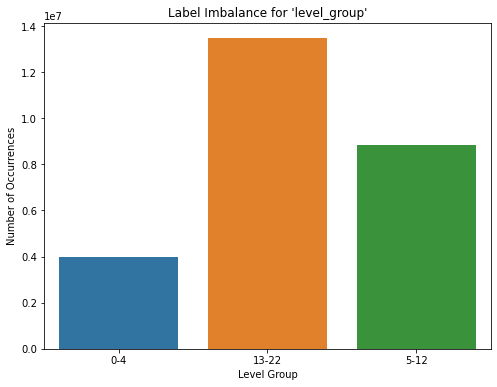

In [83]:
# Checking for label imbalance
level_group_counts = train['level_group'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=level_group_counts.index, y=level_group_counts.values)

# Set the plot title and axis labels
plt.title("Label Imbalance for 'level_group'")
plt.xlabel("Level Group")
plt.ylabel("Number of Occurrences")

# Show the plot
plt.show()

In [84]:
# from imblearn.over_sampling import RandomOverSampler

# Commented to test runtime and memory differences

# Define X and y
# X = train.drop('level_group', axis=1)
# y = train['level_group']

# # Initialize the oversampler
# oversampler = RandomOverSampler()

# # Resample the data
# X_new, y_new = oversampler.fit_resample(X, y)

# # Convert the resampled data back to a DataFrame to fix label imbalance
# train = pd.concat([X_new, y_new], axis=1)

# # Check the class distribution
# train['level_group'].value_counts()


In [85]:
# # Finding the distribution of the data and making sure it follows a normal distribution (bell curve)
# Commented to test runtime differences
# def distplots(series):
#     sns.histplot(
#     series, kde=True,
#     stat="density", kde_kws=dict(cut=3),
#     alpha=.4, edgecolor=(1, 1, 1, .4),)
#     plt.show()

# # Looping through each column except for object data types
# for col in train.select_dtypes(include=np.number).columns:
#     distplots(train[col])

In [86]:
# Commented to test runtime differences
# def boxplots(col):
#     ax = sns.boxplot(train[col])
#     ax.set(xlabel=col, ylabel='Value')
#     plt.show()

# for i in list(train.select_dtypes(exclude=["object"]).columns)[1:]:
#     boxplots(i)

# Feature Engineering

In [87]:
# Creating lists of categorical and numerical columns
categorical_columns = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
numerical_columns = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 'hover_duration']

In [88]:
# Feature engineering
def feature_engineer(train):
    dfs = []
    # Aggregating the categorical columns for each session_id and level_group column with the unique count of each category
    for i in categorical_columns:
        tmp = train.groupby(['session_id','level_group'])[i].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    # Aggregating the numerical columns for each session_id and level_group column with the mean
    for i in numerical_columns:
        tmp = train.groupby(['session_id','level_group'])[i].agg('mean')
        dfs.append(tmp)
    # Aggregating the numerical columns for each session_id and level_group column with the standard deviation
    for i in numerical_columns:
        tmp = train.groupby(['session_id','level_group'])[i].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    # Creating the new dataframe with aggregated columns (similar approach to many feature-engineered notebooks)
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [89]:
# Performing feature engineering on the dataframe
df = feature_engineer(train)
print(df.shape)
df.head()

(70686, 18)


,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,room_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.000000,7.687500,-71.43750,2389.500000,49246.539458,1.230975,-1.000000,399.272451,129.295749,3227.370757
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.000000,-130.375000,-162.00000,899.925903,126666.129584,2.358652,-1.000000,622.081128,230.373785,1305.088265
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.000000,14.304688,-57.28125,969.333313,80175.676658,2.096919,-1.000000,357.219911,137.409158,1316.408315
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.000000,-84.062500,-53.65625,1378.750000,67372.714092,1.232616,0.000000,445.973993,156.183163,2114.876406
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.101562,-30.750000,-142.87500,720.384949,777382.529186,1.825923,0.863075,529.564669,234.275228,1990.705518


<AxesSubplot:>

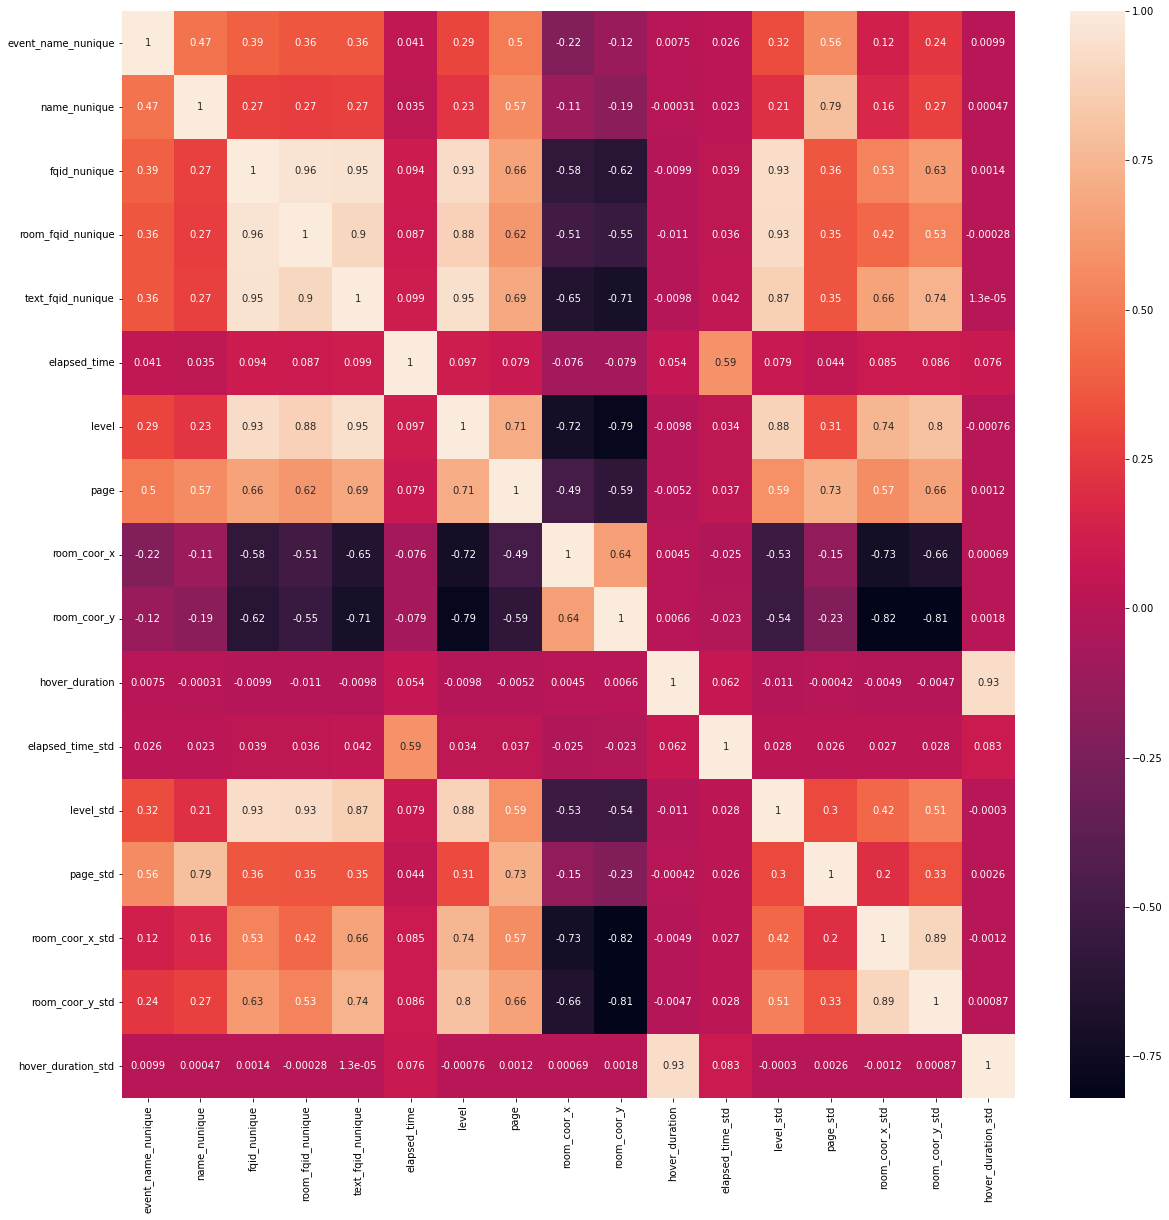

In [90]:
import seaborn as sns
# Finding the correlations between the variables using a heatmap
# High correlations between two independent variables will cause issues
plt.figure(figsize=(20,20))
corr=df.corr()
sns.heatmap(corr,annot=True)

In [91]:
# Saving the preprocessed dataframe into a .csv file
df.to_csv('preprocessed_data.csv', index=False)

# Training

In [92]:
# Creating lists of features and users
features = [c for c in df.columns if c != 'level_group']
print('We will train with', len(features) ,'features')
users = df.index.unique()
print('We will train with', len(users) ,'users info')

We will train with 17 features
We will train with 23562 users info


In [93]:
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
gkf = GroupKFold(n_splits=5)
out_of_fold = pd.DataFrame(data=np.zeros((len(users),18)), index=users)
models = {}

# Use a Group K-fold of 5 to find the cross-validation score. The for loop didn't work prior to adding enumerate.
# X = data to be split, groups = groups to create folds
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('Fold',i+1)
    # There are 18 questions. Iterate through them.
    for question in range(1,19):
        print(question,', ',end='')
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if question<=3: group = '0-4' # Trains question 1 to 3
        elif question<=13: group = '5-12' # Trains questions 4 to 13
        elif question<=22: group = '13-22' # Trains questions 14 to 18
            
        # Manual train/test split based on other notebook approaches
        
        # Training data
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == group]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==question].set_index('session').loc[train_users]
        
        # Validation data
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == group]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==question].set_index('session').loc[valid_users]
        
        # Training the classifer model
        # Extreme Gradient Boosting
        clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        # Neural Network
        # clf = Sequential()
        # clf.add(Dense(64, activation='relu'))
        # Preventing overfitting with dropout layer
        # clf.add(Dropout(0.5))
        # clf.add(Dense(32, activation='relu'))
        # Preventing overfitting with dropout layer
        # clf.add(Dropout(0.5))
        # clf.add(Dense(1, activation='sigmoid'))

        # Compile the model
        # clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Define the individual models
        # random_forest = RandomForestClassifier(n_estimators=100)
        # knn = KNeighborsClassifier(n_neighbors=5)

        # Define the ensemble model
        # clf = VotingClassifier(estimators=[('random_forest', random_forest), ('knn', knn)], voting='hard')
        
        # Fitting the model according to a similar approach to others
        clf.fit(train_x[features].astype('float32'), train_y['correct'])
        
        # Saving the model
        models[f'{group}_{question}'] = clf
        # Use predict instead for neural network and ensemble model
        out_of_fold.loc[valid_users, question-1] = clf.predict_proba(valid_x[features].astype('float32'))[:,1]
        # out_of_fold.loc[valid_users, question-1] = clf.predict(valid_x[features].astype('float32')).flatten()
    
    print()

Fold 1
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
Fold 2
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
Fold 3
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
Fold 4
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
Fold 5
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 


# Feature Importances

In [94]:
# Extract feature importances
feature_importances = []
for question, model in models.items():
    feature_importances.append(model.feature_importances_)

# Calculate mean feature importance for each feature across all models
mean_importances = np.mean(feature_importances, axis=0)

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': mean_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.reset_index(drop=True, inplace=True)

# Display the feature importances table
print(importance_df)

               Feature  Importance
0    room_fqid_nunique    0.120788
1    text_fqid_nunique    0.095968
2       hover_duration    0.057128
3                level    0.056084
4   hover_duration_std    0.054545
5     elapsed_time_std    0.054170
6         name_nunique    0.053822
7         fqid_nunique    0.053314
8             page_std    0.053266
9         elapsed_time    0.052762
10                page    0.051540
11           level_std    0.051262
12     room_coor_x_std    0.050609
13         room_coor_x    0.049344
14     room_coor_y_std    0.049220
15         room_coor_y    0.049155
16  event_name_nunique    0.047024


# Optimizing Cross-validation Score and Creating Graphs

In [95]:
# Adding the true labels to the true dataframe (Uses similar approach to many notebooks)
true = out_of_fold.copy()
# Iterating through the 18 questions
for question in range(18):
    # Adding the true labels from targets to the true dataframe, so they can be compared with out_of_fold data
    tmp = targets.loc[targets.q == question+1].set_index('session').loc[users]
    true[question] = tmp.correct.values

In [96]:
from sklearn.metrics import f1_score

# Find the best threshold to convert probabilities. This technique is similar to that from multiple notebooks.
scores = []; thresholds = []
best_score = 0; best_threshold = 0

# Using a similar for loop to find the thresholds as some other notebooks
for threshold in np.arange(0.4,0.81,0.01):
    # Printing the F1-score
    print(f'{threshold:.02f}')
    predictions = (out_of_fold).values.reshape((-1)) > threshold.astype('int')
    # Using the macro F1-score
    f1_macro = f1_score(true.values.reshape((-1)), predictions, average='macro') 
    # Updating the scores and thresholds lists
    scores.append(f1_macro)
    thresholds.append(threshold)
    # Updating the best score and best threshold if the new F1-score is greater than the previous
    if f1_macro > best_score:
        best_score = f1_macro
        best_threshold = threshold

0.40
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.50
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.60
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.70
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.80


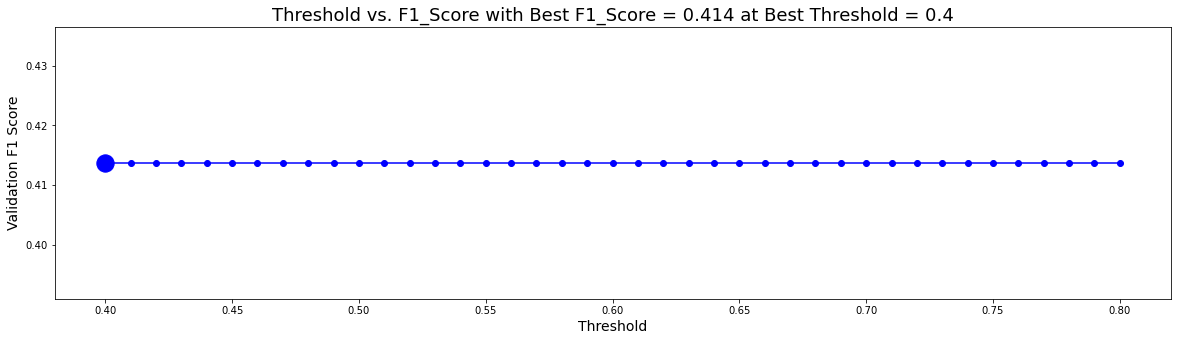

In [97]:
# Plot the threshold against the F1-score
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

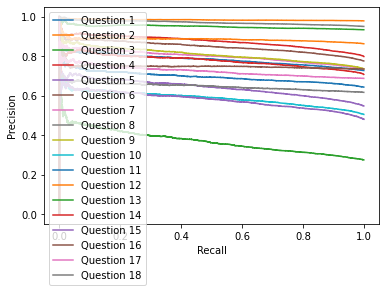

In [98]:
# Compute precision and recall for different threshold values
from sklearn.metrics import precision_recall_curve
preds = out_of_fold.values.reshape(-1, 18)
labels = true.values.reshape(-1, 18)

precision = dict()
recall = dict()
thresholds = dict()

# Filling the precision, recall, and threshold dictionaries for each of the 18 questions
for i in range(18):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(labels[:, i], preds[:, i])
    
# Plotting the precision-recall curve for each of the 18 questions
for i in range(18):
    plt.plot(recall[i], precision[i], label=f'Question {i+1}')
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Predicting on the Testing Data

In [99]:
# Making the testing environment
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

Exception: You can only call `make_env()` once.

In [ ]:
# Creating a dictionary with keys of the levek groups, and values of the questions
groups = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

# Using a similar approach a lot of notebooks used to perform the test
for (sample_submission, test) in iter_test:
    # Feature engineering on the testing dataset
    df = feature_engineer(test)
    group = test.level_group.values[0]
    # Get the range of questions for the current level_group from the 'groups' dictionary
    lower_bound,upper_Bound = groups[group]
    # Iterate through the range of questions for the current level_group
    for question in range(lower_bound,upper_bound):
        clf = models[f'{group}_{question}']
        # Predict the probability of a correct answer using the model
        p = clf.predict_proba(df[features].astype('float32'))[:,1]
        # Use for ensemble and neural network
        # p = clf.predict(df[features].astype('float32')).flatten()
        # Update the sample_submission DataFrame with the prediction for the current question
        mask = sample_submission.session_id.str.contains(f'q{question}')
        # Using the same correct metric most notebooks used
        sample_submission.loc[mask,'correct'] = int(p.item()>best_threshold)
    # Making the predictions
    env.predict(sample_submission)

# Submission.csv File

In [ ]:
# Checking the submission.csv file
df = pd.read_csv('submission.csv')
print(df.shape)
df.head()